<h3 id='nav'>Train,Predict&Validate. Minresol vs Set_val2. </h3>

<a href='#1'> Тренируемся на minresol, исключая общие цепи.</a>
<ol>
<li><a href='#1.1'>Результаты на set_val2, исключая общие цепи.</a></li>
<li><a href='#1.2'>Результаты на set_val2, включая общие цепи.</a></li>
<li><a href='#1.3'>Результаты на minresol.</a></li>
</ol>

<a href='#2'>Тренируемся на set_val2, исключая общие цепи.</a>
<ol>
<li><a href='#2.1'>Результаты на minresol, исключая общие цепи.</a></li>
<li><a href='#2.2'>Результаты на minresol, включая общие цепи.</a></li>
<li><a href='#2.3'>Результаты на set_val2.</a></li>
</ol>

<a href="https://pollytikhonova.github.io/coursework/validation/"><img src="https://pollytikhonova.github.io/coursework/GitHub-Mark-32px.png" alt="В репозиторий" title="В репозиторий" style="max-width:100%;  display: inline-block; margin-right: 10px;"></a> <a href="Code.ipynb" download target="_blank">Скачать этот ipunb-файл можно здесь</a>

In [1]:
import sys
sys.path.insert(0, '../../basic codes')

import class_magnesium_not_drop_na
from class_magnesium_not_drop_na import *

from matplotlib.backends.backend_pdf import PdfPages

import sys
from IPython.core.display import clear_output
def change_output(x):
    clear_output()
    sys.stdout.write(x)
    sys.stdout.flush()

import xgboost as xgb

In [2]:
import importlib
importlib.reload(class_magnesium_not_drop_na)
from class_magnesium_not_drop_na import *

In [10]:
class Magnesium_validation(Magnesium):    
    def __init__(self, validation_file, drop_common = True,  *args, **kwargs):
        change_output('Loading data...')
        super(Magnesium_validation, self).__init__(*args, **kwargs)
        change_output('Loading validation data...')
        self.validation_data = pd.read_table(validation_file).fillna(method = 'backfill', axis = 0)
        if np.sum(self.validation_data.isnull().any(axis=1)) > 0:
            self.validation_data.fillna(method = 'pad', axis = 0, inplace = True)
        self.validation_data = self.validation_data[~(self.validation_data['chainlen']>1000)]
        angles = ['p', 'phase-angle', 'e-z',
                  'tm', 'sszp', 'etap', 'etapp', 
                  'splay', 'thetap', 'thetapp']
        angles = np.ravel([[''.join([i,j]) for i in angles] for j in ['m2', 'm1', '', '1', '2']])
        self.validation_data.drop(angles, axis=1)
        self.data.drop(angles, axis=1)
        if ('DSSR' in self.data.columns):
            self.data.drop('DSSR', axis=1, inplace=True)
        if ('DSSR' in self.validation_data.columns):
            self.validation_data.drop('DSSR', axis=1, inplace=True)
        change_output('Data loaded')
        change_output('Data processing')        
        self.common_data = self.validation_data[self.validation_data['pdb_chain'].isin(self.data['pdb_chain'])]
       # self.data = self.data[~self.data['pdb_chain'].isin(self.common_data['pdb_chain'])]
        if drop_common:
            self.validation_data = self.validation_data[~self.validation_data['pdb_chain'].isin(self.common_data['pdb_chain'])]
        self.x_test = np.matrix(self.validation_data[list(self.validation_data.columns)[1:-1]])
        self.y_test = np.array(self.validation_data[list(self.validation_data.columns)[-1]])
        self.data_numpy = np.matrix(self.data)
        self.x = self.data_numpy[:, 1:-1]
        self.y = np.array(self.data_numpy[:,-1].flatten().tolist()[0])
        change_output("Data processed")
        
    def train(self, n_splits):
        change_output("Start training...")
        self.trained_model_validation = self.model
        x = self.x
        y = self.y
        sss = StratifiedShuffleSplit(n_splits = n_splits, test_size = 0.3, random_state = 0)
        rus = RandomUnderSampler(ratio = 'auto', random_state=42)
        
        splitted = sss.split(x, y) 
        iterator = tqdm_notebook(splitted, desc = "Splits", leave = True) if tqdm else splitted            
        for train_index, test_index in iterator:               
            x_train, y_train = rus.fit_sample(x[train_index], y[train_index])
            x_test, y_test = x[test_index], y[test_index]
            self.trained_model_validation.fit(x_train, y_train)
            self.train_score.append(self.trained_model_validation.score(x_train, y_train))
            self.test_score.append(self.trained_model_validation.score(x_test, y_test))
        if not os.path.isdir('trained_models'):
            os.mkdir('trained_models')
        model_name = '%s_depth=%d_leaves=%d_%s_validation'%(re.split("\.|\'", str(self.trained_model_validation.__class__))[-2],
                                              self.trained_model_validation.__dict__['max_depth'], 
                                              self.trained_model_validation.__dict__['min_samples_leaf'],
                                              self.filename)
        with open("trained_models/"+model_name+".sav", 'wb') as file_to_save:
            pickle.dump(self.trained_model_validation, file_to_save)
        change_output("Trained")
        return [x[test_index], y[test_index]]
            
            
    def compute_validated(self, n_splits = 3):
        x_test, y_test = self.train(n_splits)
        data = self.predict(x = self.x_test, y = self.y_test, model=self.trained_model_validation)
        self.show_plots(data['plots'])  
        plt.text(0.02, 0.5, 'Predict', fontsize=14)
        data_train = self.predict(x = x_test, y = y_test, model=self.trained_model_validation)
        self.show_plots(data_train['plots'])  
        plt.text(0.02, 0.5, 'Train', fontsize=14)
        self.validation_data['prediction'] = data['prediction']
        self.validation_data['probability'] = data['probability']
        return data        

<h3 id='1'> Тренируемся на minresol <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

In [11]:
#fold = 'https://tikhonovapolly.files.wordpress.com/2017/09/'
fold = '../../main_datasets/'
m_straight_without = Magnesium_validation(fold+'set_val2_A_7_new.csv', drop_common = True, file_ = "set_minresol_a_7_1000_new.csv", fold = fold,
     model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_depth = 39, min_samples_leaf = 1))

Data processed

In [12]:
m_straight_without.train(n_splits=5);

Trained

In [22]:
print('Train score: mean / std - %.3f / %.3f' %
      (np.array(m_straight_without.train_score).mean(),np.array(m_straight_without.train_score).std()))
print('Test score: mean / std - %.3f / %.3f' % 
      (np.array(m_straight_without.test_score).mean(),np.array(m_straight_without.test_score).std()))

Train score: mean / std - 1.000 / 0.000
Test score: mean / std - 0.835 / 0.002


<h3 id='1.1'> Результаты на set_val2 исключая совпадающие с трейном цепи. <a href='#nav'><img src='to_nav.png' height='40px' width='40px' align='right' style="display: inline-block; margin-top: -10px;"></a></h3>

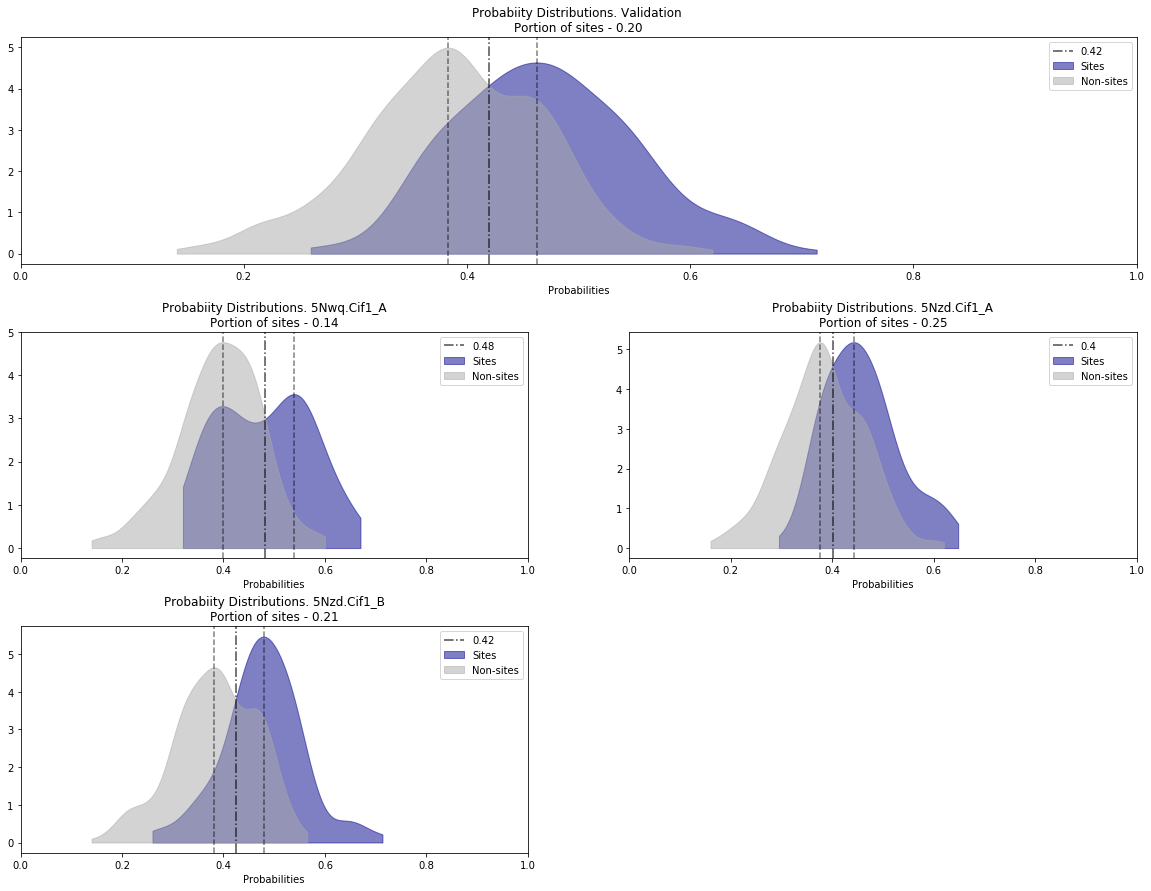

In [6]:
fig = plt.figure(figsize = (20, 15))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.3)
data_straight_without = m_straight_without.predict(x = m_straight_without.x_test,
                                                   y = m_straight_without.y_test, 
                                                   model=m_straight_without.trained_model_validation)
n = np.unique(m_straight_without.validation_data['pdb_chain']).shape[0]//2+2
k = 0
fig.add_subplot(n,1, 1)
plot = data_straight_without['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probabiity Distributions. Validation \nPortion of sites - %.2f'%(np.sum(m_straight_without.y_test==1)/m_straight_without.y_test.shape[0]))
for i,chain in enumerate(np.unique(m_straight_without.validation_data['pdb_chain'])):    
    dataset = m_straight_without.validation_data[m_straight_without.validation_data['pdb_chain'] == chain]    
    x_test = np.matrix(dataset[list(m_straight_without.validation_data.columns)[1:-1]])
    y_test = np.array(dataset[list(m_straight_without.validation_data.columns)[-1]])
    if np.sum(y_test==1) > 0:
        fig.add_subplot(n,2, i+3-k)
        data = m_straight_without.predict(x = x_test,
                                          y = y_test, 
                                          model=m_straight_without.trained_model_validation)
        plot = data['plots']['prob_density']
        [eval(plot_string) for plot_string in plot]
        plt.title('Probabiity Distributions. %s\nPortion of sites - %.2f'%(chain.title(), np.sum(y_test==1)/y_test.shape[0]))
    else:
        print("Chain %s has no sites. "%(chain))
        k += 1

<h3 id='1.2'> Результаты на set_val2, включая совпадающие с трейном цепи.<a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

In [ ]:
m_straight_with = Magnesium_validation('../main_datasets/set_val2_A_7_new.csv', drop_common = False, file_ = "set_minresol_a_7_1000_new.csv", fold = fold,
     model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_depth = 39, min_samples_leaf = 1))
m_straight_with.trained_model_validation = m_straight_without.trained_model_validation

fig = plt.figure(figsize = (20, 17))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.3)
data_straight_with = m_straight_with.predict(x = m_straight_with.x_test,
                                                   y = m_straight_with.y_test, 
                                                   model=m_straight_with.trained_model_validation)

n = np.unique(m_straight_with.common_data['pdb_chain']).shape[0]//2+2
k = 0

fig.add_subplot(n,1, 1)
plot = data_straight_with['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probabiity Distributions. Validation \nPortion of sites - %.2f'%(np.sum(m_straight_with.y_test==1)/m_straight_with.y_test.shape[0]))


for i,chain in enumerate(np.unique(m_straight_with.common_data['pdb_chain'])):    
    dataset = m_straight_with.common_data[m_straight_with.common_data['pdb_chain'] == chain]    
    x_test = np.matrix(dataset[list(m_straight_with.common_data.columns)[1:-1]])
    y_test = np.array(dataset[list(m_straight_with.common_data.columns)[-1]])
    if np.sum(y_test==1) > 0:
        fig.add_subplot(n,2, i+3-k)
        data = m_straight_with.predict(x = x_test,
                                          y = y_test, 
                                          model=m_straight_with.trained_model_validation)
        plot = data['plots']['prob_density']
        [eval(plot_string) for plot_string in plot]
        #m_straight_with.show_plots(plot)  
        plt.title('Probabiity Distributions. %s\nPortion of sites - %.2f'%(chain.title(), np.sum(y_test==1)/y_test.shape[0]))
    else:
        print("Chain %s has no sites. "%(chain))
        k += 1

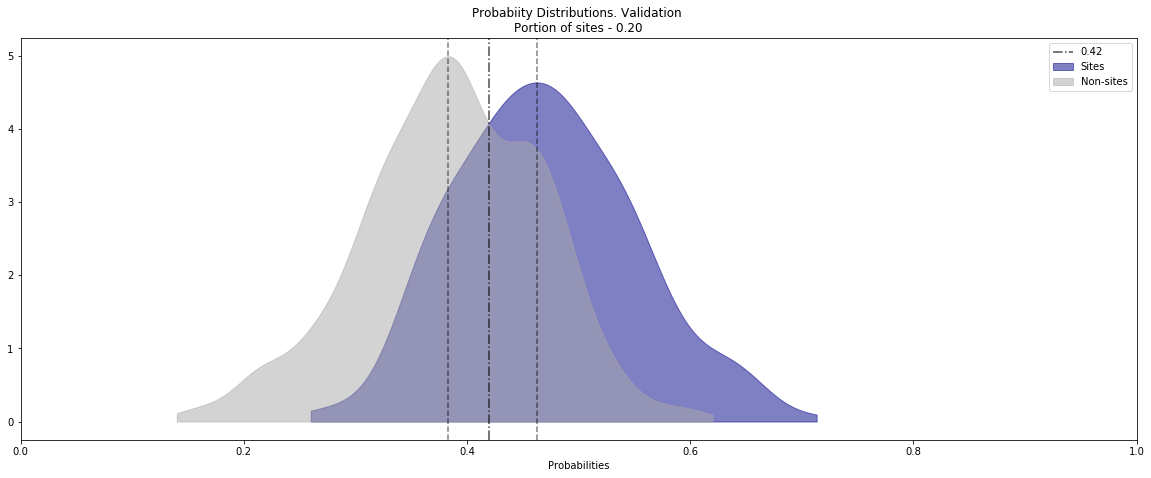

In [17]:
fig = plt.figure(figsize = (20, 17))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.3)
data_straight_with = m_straight_with.predict(x = m_straight_with.x_test,
                                                   y = m_straight_with.y_test, 
                                                   model=m_straight_with.trained_model_validation)

n = np.unique(m_straight_with.common_data['pdb_chain']).shape[0]//2+2
k = 0

fig.add_subplot(n,1, 1)
plot = data_straight_with['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probabiity Distributions. Validation \nPortion of sites - %.2f'%(np.sum(m_straight_with.y_test==1)/m_straight_with.y_test.shape[0]))


for i,chain in enumerate(np.unique(m_straight_with.common_data['pdb_chain'])):    
    dataset = m_straight_with.common_data[m_straight_with.common_data['pdb_chain'] == chain]    
    x_test = np.matrix(dataset[list(m_straight_with.common_data.columns)[1:-1]])
    y_test = np.array(dataset[list(m_straight_with.common_data.columns)[-1]])
    if np.sum(y_test==1) > 0:
        fig.add_subplot(n,2, i+3-k)
        data = m_straight_with.predict(x = x_test,
                                          y = y_test, 
                                          model=m_straight_with.trained_model_validation)
        plot = data['plots']['prob_density']
        [eval(plot_string) for plot_string in plot]
        #m_straight_with.show_plots(plot)  
        plt.title('Probabiity Distributions. %s\nPortion of sites - %.2f'%(chain.title(), np.sum(y_test==1)/y_test.shape[0]))
    else:
        print("Chain %s has no sites. "%(chain))
        k += 1

<h3 id='1.3'> Результаты на minresol (на которой тренировались). <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

Scores mean:0.86
Scores std^ 0.01


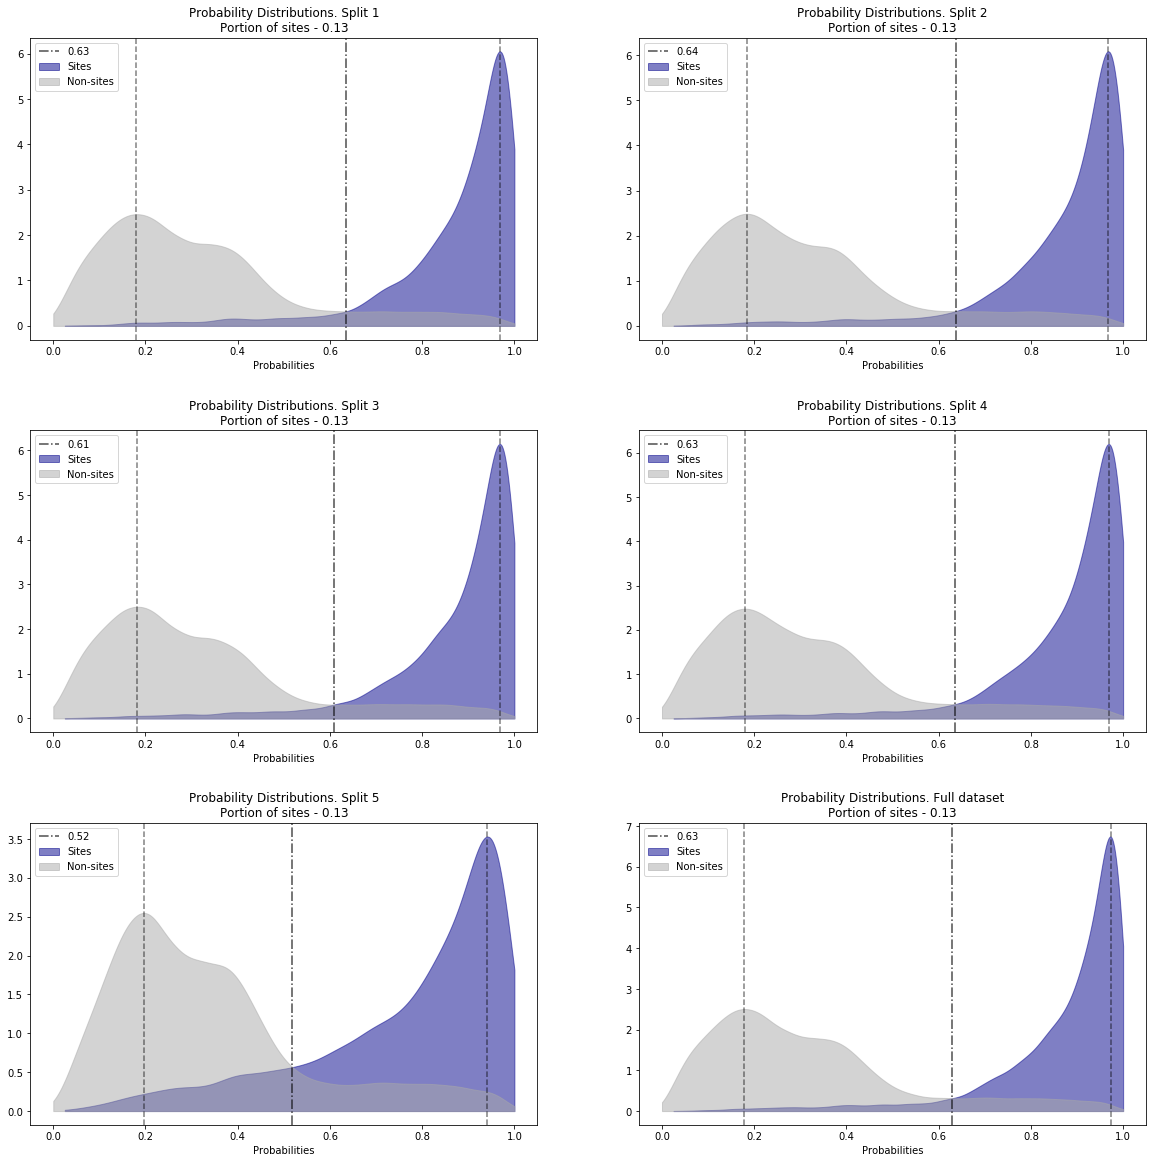

In [8]:
fig = plt.figure(figsize = (20, 20))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.3)
n = 3
k = 0
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 0)
split = sss.split(m_straight_without.x, m_straight_without.y) 
scores = []
for train_index, test_index in split:               
    x_test, y_test = m_straight_without.x[test_index], m_straight_without.y[test_index]
    k += 1
    fig.add_subplot(n,2, k)
    data = m_straight_without.predict(x = x_test,
                                          y = y_test, 
                                          model=m_straight_without.trained_model_validation)
    scores.append(data['test_score'])
    plot = data['plots']['prob_density']
    [eval(plot_string) for plot_string in plot]
    plt.title('Probability Distributions. Split %d\nPortion of sites - %.2f'%(k, np.sum(y_test==1)/y_test.shape[0]))
k += 1
fig.add_subplot(n,2, k)
data = m_straight_without.predict(x = m_straight_without.x,
                                  y = m_straight_without.y, 
                                  model=m_straight_without.trained_model_validation)
plot = data['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probability Distributions. Full dataset\nPortion of sites - %.2f'%(np.sum(y_test==1)/y_test.shape[0]));
print('Scores mean:%.2f'%np.array(scores).mean())
print('Scores std: %.2f'%np.array(scores).std())

<h3 id='2'> Тренируемся на set_val2. <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

In [24]:
fold = '../../main_datasets/'
m_reverse_without = Magnesium_validation(fold+'set_minresol_a_7_1000_new.csv', drop_common = True, file_ = "set_val2_A_7_new.csv", fold = fold,
     model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_depth = 39, min_samples_leaf = 1))

Data processed

In [25]:
m_reverse_without.train(n_splits=5);

Trained

In [28]:
print('Train score: mean/std - %.3f / %.3f' %
      (np.array(m_reverse_without.train_score).mean(),np.array(m_reverse_without.train_score).std()))
print('Test score: mean/std - %.3f / %.3f' % 
      (np.array(m_reverse_without.test_score).mean(),np.array(m_reverse_without.test_score).std()))

Train score: mean/std - 1.000 / 0.000
Test score: mean/std - 0.740 / 0.010


<h3 id='2.1'> Результаты на minresol, исключая совпадающие с трейном цепи. <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

Chain 3jb9.cif1_P has no sites. 
Chain 3p59.cif1_C has no sites. 
Chain 3p59.cif1_D has no sites. 
Chain 3p59.cif1_G has no sites. 
Chain 3p59.cif1_H has no sites. 
Chain 4g6r.cif1_C has no sites. 
Chain 4g6r.cif1_D has no sites. 
Chain 4qjh.cif1_B has no sites. 
Chain 5ew4.cif1_A has no sites. 
Chain 5f0q.cif1_E has no sites. 
Chain 5jb2.cif1_Y has no sites. 


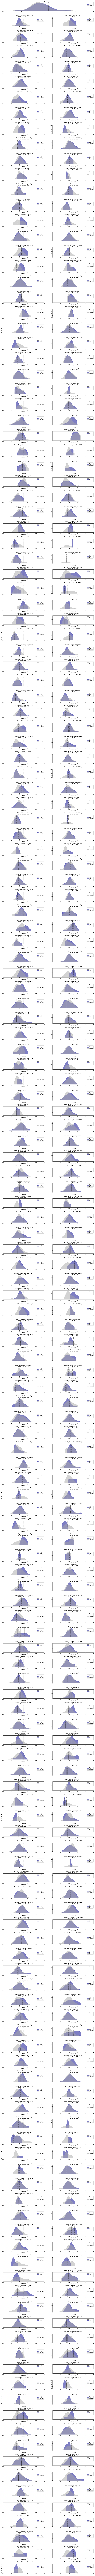

In [11]:
fig = plt.figure(figsize = (20, 600))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.7)
data_reverse_without = m_reverse_without.predict(x = m_reverse_without.x_test,
                                                   y = m_reverse_without.y_test, 
                                                   model=m_reverse_without.trained_model_validation)
n = np.unique(m_reverse_without.validation_data['pdb_chain']).shape[0]//2+1
k = 0
fig.add_subplot(n,1, 1)
plot = data_reverse_without['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probabiity Distributions. Validation')
for i,chain in enumerate(np.unique(m_reverse_without.validation_data['pdb_chain'])):    
    dataset = m_reverse_without.validation_data[m_reverse_without.validation_data['pdb_chain'] == chain]    
    x_test = np.matrix(dataset[list(m_reverse_without.validation_data.columns)[1:-1]])
    y_test = np.array(dataset[list(m_reverse_without.validation_data.columns)[-1]])
    if np.sum(y_test==1) > 0:
        fig.add_subplot(n,2, i+3-k)
        data = m_reverse_without.predict(x = x_test,
                                          y = y_test, 
                                          model=m_reverse_without.trained_model_validation)
        plot = data['plots']['prob_density']
        [eval(plot_string) for plot_string in plot]
        plt.title('Probabiity Distributions. %s\nPortion of sites - %.2f'%(chain.title(), np.sum(y_test==1)/y_test.shape[0]))
    else:
        print("Chain %s has no sites. "%(chain))
        k += 1

<h3 id='2.2'> Результаты на minresol, исключая совпадающие с трейном цепи. <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

In [ ]:
m_reverse_with = Magnesium_validation('../main_datasets/set_minresol_a_7_1000_new.csv', drop_common = False, file_ = "set_val2_A_7_new.csv", fold = fold,
     model = RandomForestClassifier(n_estimators=200, n_jobs=-1, criterion='gini', max_depth = 39, min_samples_leaf = 1))
m_reverse_with.trained_model_validation = m_reverse_without.trained_model_validation

fig = plt.figure(figsize = (20, 50))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.7)
data_reverse_with = m_reverse_with.predict(x = m_reverse_with.x_test,
                                                   y = m_reverse_with.y_test, 
                                                   model=m_reverse_with.trained_model_validation)
n = np.unique(m_reverse_with.common_data['pdb_chain']).shape[0]//2+2
k = 0
fig.add_subplot(n,1, 1)
plot = data_reverse_with['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probabiity Distributions. Validation \nPortion of sites - %.2f'%(np.sum(m_reverse_with.y_test==1)/m_reverse_with.y_test.shape[0]))

for i,chain in enumerate(np.unique(m_reverse_with.common_data['pdb_chain'])):    
    dataset = m_reverse_with.common_data[m_reverse_with.common_data['pdb_chain'] == chain]    
    x_test = np.matrix(dataset[list(m_reverse_with.common_data.columns)[1:-1]])
    y_test = np.array(dataset[list(m_reverse_with.common_data.columns)[-1]])
    if np.sum(y_test==1) > 0:
        fig.add_subplot(n,2, i+3-k)
        data = m_reverse_with.predict(x = x_test,
                                          y = y_test, 
                                          model=m_reverse_with.trained_model_validation)
        plot = data['plots']['prob_density']
        [eval(plot_string) for plot_string in plot]
        #m_reverse_with.show_plots(plot)  
        plt.title('Probabiity Distributions. %s\nPortion of sites - %.2f'%(chain.title(), np.sum(y_test==1)/y_test.shape[0]))
    else:
        print("Chain %s has no sites. "%(chain))
        k += 1

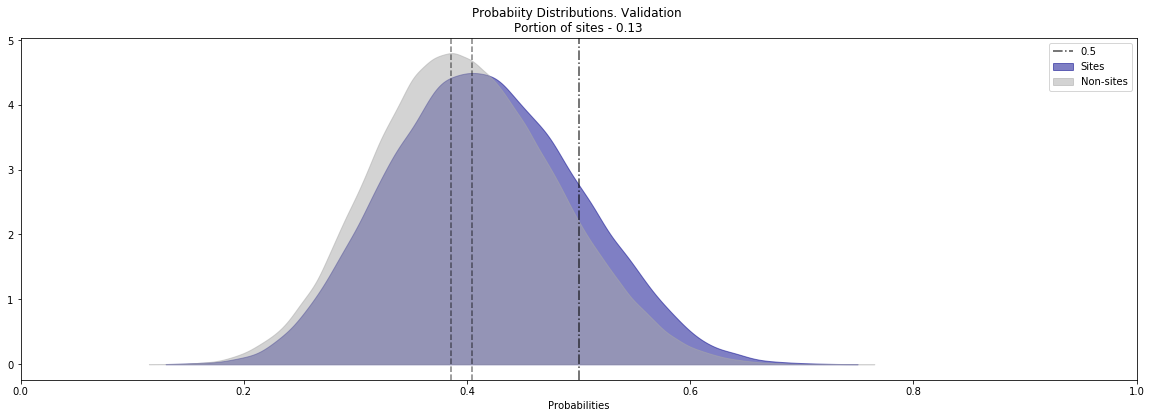

In [20]:
fig = plt.figure(figsize = (20, 17))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.7)
data_reverse_with = m_reverse_with.predict(x = m_reverse_with.x_test,
                                                   y = m_reverse_with.y_test, 
                                                   model=m_reverse_with.trained_model_validation)
n = np.unique(m_reverse_with.common_data['pdb_chain']).shape[0]//2+2
k = 0
fig.add_subplot(n,1, 1)
plot = data_reverse_with['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probabiity Distributions. Validation \nPortion of sites - %.2f'%(np.sum(m_reverse_with.y_test==1)/m_reverse_with.y_test.shape[0]))

for i,chain in enumerate(np.unique(m_reverse_with.common_data['pdb_chain'])):    
    dataset = m_reverse_with.common_data[m_reverse_with.common_data['pdb_chain'] == chain]    
    x_test = np.matrix(dataset[list(m_reverse_with.common_data.columns)[1:-1]])
    y_test = np.array(dataset[list(m_reverse_with.common_data.columns)[-1]])
    if np.sum(y_test==1) > 0:
        fig.add_subplot(n,2, i+3-k)
        data = m_reverse_with.predict(x = x_test,
                                          y = y_test, 
                                          model=m_reverse_with.trained_model_validation)
        plot = data['plots']['prob_density']
        [eval(plot_string) for plot_string in plot]
        #m_reverse_with.show_plots(plot)  
        plt.title('Probabiity Distributions. %s\nPortion of sites - %.2f'%(chain.title(), np.sum(y_test==1)/y_test.shape[0]))
    else:
        print("Chain %s has no sites. "%(chain))
        k += 1

<h3 id='2.3'> Результаты на set_val_a_7 (на которой тренировались). <a href='#nav'><img src='to_nav.png' align='right' height='40px' width='40px' style="display: inline-block; margin-top:-10px"></a></h3>

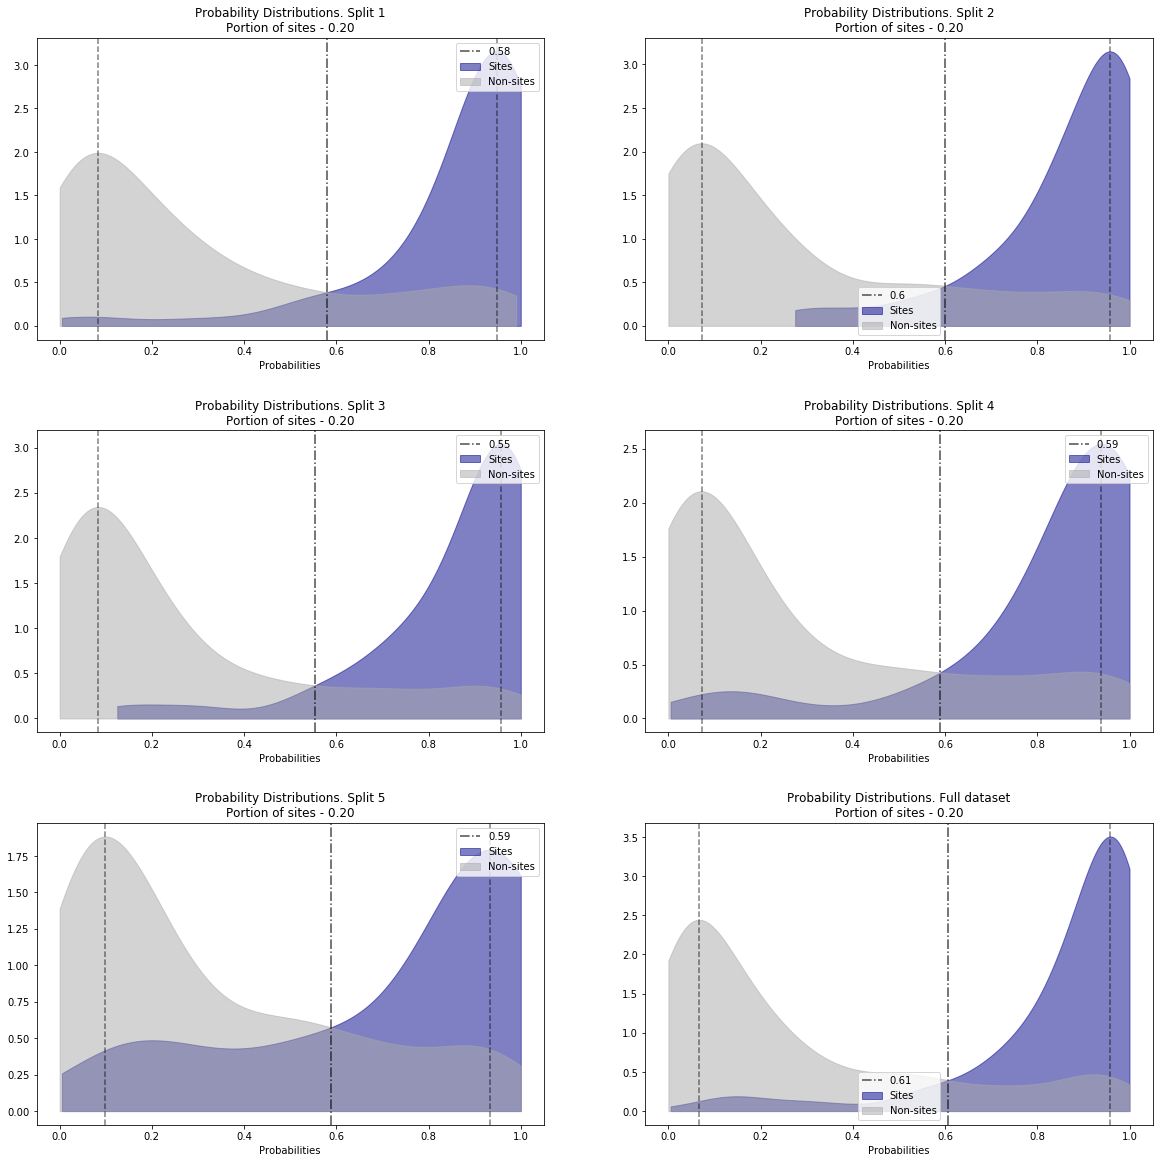

In [13]:
fig = plt.figure(figsize = (20, 20))
fig.set_facecolor('white')
plt.subplots_adjust(hspace=0.3)
n = 3
k = 0
sss = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 0)
split = sss.split(m_reverse_without.x, m_reverse_without.y) 
for train_index, test_index in split:               
    x_test, y_test = m_reverse_without.x[test_index], m_reverse_without.y[test_index]
    k += 1
    fig.add_subplot(n,2, k)
    data = m_reverse_without.predict(x = x_test,
                                          y = y_test, 
                                          model=m_reverse_without.trained_model_validation)
    plot = data['plots']['prob_density']
    [eval(plot_string) for plot_string in plot]
    plt.title('Probability Distributions. Split %d\nPortion of sites - %.2f'%(k, np.sum(y_test==1)/y_test.shape[0]))
k += 1
fig.add_subplot(n,2, k)
data = m_reverse_without.predict(x = m_reverse_without.x,
                                  y = m_reverse_without.y, 
                                  model=m_reverse_without.trained_model_validation)
plot = data['plots']['prob_density']
[eval(plot_string) for plot_string in plot]
plt.title('Probability Distributions. Full dataset\nPortion of sites - %.2f'%(np.sum(y_test==1)/y_test.shape[0]));